In [95]:
# Imports
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc


from sklearn.linear_model import LogisticRegression #xxxxxx
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression #xxxxxxx
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight



from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler




In [96]:
# Konfiguration
# input = "/Users/juliaschmid/Desktop/MALE01_TEST/"
# INPUT_FILE = os.path.join(input, "cs-training.csv")
# PROFILE_FILE = os.path.join(input, "hotel_bookings.html")

# Quelle Datensatz: # https://www.kaggle.com/c/GiveMeSomeCredit/data?select=cs-training.csv

INPUT_FILE = "cs-training.csv"

df = pd.read_csv(INPUT_FILE, encoding='latin1')

In [97]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [98]:
df.shape

(150000, 12)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [100]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


## Datenaufbereitung

Duplikate 

In [101]:
print('Dieser Datensatz besitz ' + str(df.duplicated().sum()) + ' Duplikate.')

Dieser Datensatz besitz 0 Duplikate.


NaNs

In [102]:
df.isnull().sum()[df.isnull().sum() > 0]

MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

In [103]:
# Überarbeiten!!!!!!!!

df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['MonthlyIncome'] = df['MonthlyIncome'].astype(int)

df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)
df['NumberOfDependents'] = df['NumberOfDependents'].astype(int)

/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_83259/926256545.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_83259/926256545.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

Irrelevante Spalte löschen

In [104]:
print(df.columns)

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


In [105]:
notRelevantVar =['Unnamed: 0']
df.drop(notRelevantVar, axis = 1, inplace = True)

Kategorische und Numerische Variablen bestimmen

In [106]:
categoricalVar = [col for col in df if df[col].dtype == 'object']
print('Kategorische Variablen: ' + str(categoricalVar))

numericalVar = [col for col in df if df[col].dtype != 'object']
print('Numerische Variablen: '+ str(numericalVar))

Kategorische Variablen: []
Numerische Variablen: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  int64  
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  int64  
dtype

## Correlationsmatrix

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines   -0.001802
age                                    -0.115386
NumberOfTime30-59DaysPastDueNotWorse    0.125587
DebtRatio                              -0.007602
MonthlyIncome                          -0.017151
NumberOfOpenCreditLinesAndLoans        -0.029669
NumberOfTimes90DaysLate                 0.117175
NumberRealEstateLoansOrLines           -0.007038
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046869
Name: SeriousDlqin2yrs, dtype: float64


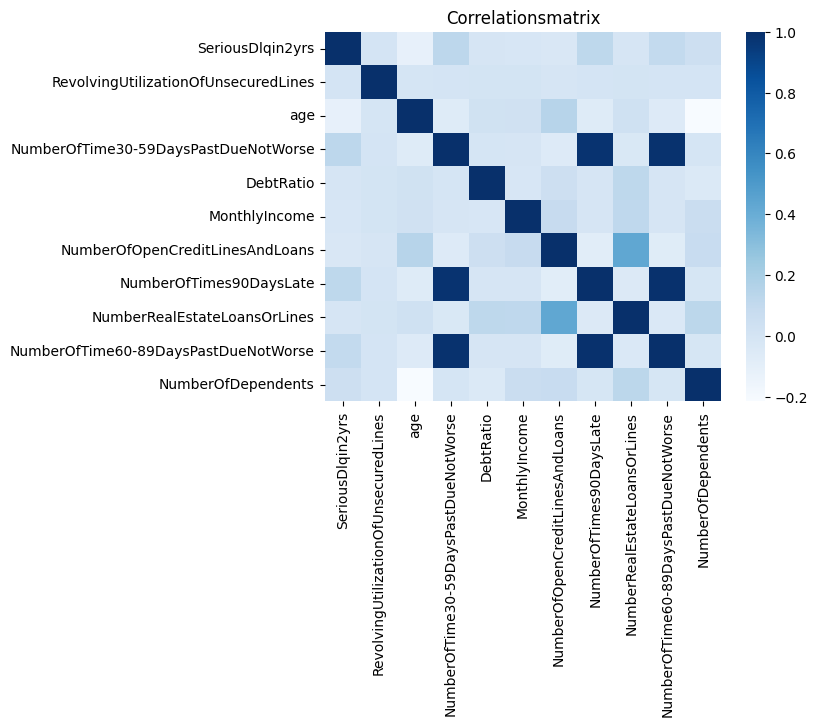

In [108]:
corr_mat = df[numericalVar].corr()

# Heatmap erstellen
sns.heatmap(corr_mat, cmap='Blues')
plt.title('Correlationsmatrix')

#plt.savefig('CorrelationMatrixHeatmap.png', bbox_inches = 'tight', pad_inces = 0.0)

# Attribute ausgeben, die mit dem Attribut 'SeriousDlqin2yrs' korrelieren
print(corr_mat['SeriousDlqin2yrs'])

In [109]:
# Kopie des aufbereiteten Datensatzes erstellen
df_copy = df

# Machine Learning 

## Daten in Test-/Trainingsdaten teilen

In [110]:
df['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [111]:
df_result = pd.DataFrame(columns=['model','accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

def runModel(ml_model, X_train, y_train, X_test, y_test, name, df_result, algoAdaption = False):

    print('[INFO] Model ' + name + ' started...')

    name = name.split()[0]
    name = name.replace(" ", "")

    if(name == 'KNN'):
        ml_model.fit(X_train, y_train)
    else:
        sampleWeights = compute_sample_weight(class_weight='balanced', y=y_train) if algoAdaption else None
        ml_model.fit(X_train, y_train, sample_weight = sampleWeights)
    
    y_pred_model = ml_model.predict(X_test)

    print('[INFO] Model ' + name + ' finished.')

    return(y_pred_model)
           
def getResults(y_pred_model, y_test, name, df_result):

    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model)
    recall = recall_score(y_test, y_pred_model)
    f1 = f1_score(y_test, y_pred_model)
    roc_auc = roc_auc_score(y_test, y_pred_model)

    fpr, tpr, _ = roc_curve(y_test, y_pred_model)
    roc_auc = auc(fpr, tpr)

    temp = pd.DataFrame([[name, accuracy, precision, recall, f1,roc_auc ]], columns=['model','accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    df_result = pd.concat([df_result, temp], ignore_index=True)

    return df_result, (fpr, tpr, roc_auc)

def runAndPredict(nEighbors,X_train, y_train, X_test, y_test, df_result, model_kind, balanced = None, weightVar = 'uniform', algo = False ):
    # Model 
    ratioVar = sum(y_train == 0) / sum(y_train == 1)
    ratio = 1 if algo == False else ratioVar

    rf_model = RandomForestClassifier(random_state=123, class_weight = balanced)
    knn_model = KNeighborsClassifier(n_neighbors=nEighbors, weights=weightVar)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric = 'auc', random_state=123, n_estimators=500, learning_rate=0.2, scale_pos_weight=ratio )
    logReg_model = LogisticRegression(class_weight=balanced)

    ml_model = {
        f'RF {model_kind}': rf_model,
        f'KNN {model_kind}': knn_model,
        f'XGB {model_kind}': xgb_model,
        f'LogReg {model_kind}': logReg_model
    }
    roc_data_dict = {}

    for modelName, model in ml_model.items():
        y_pred = runModel(model, X_train, y_train, X_test, y_test, modelName, df_result)
        df_result, roc_data = getResults(y_pred, y_test, modelName, df_result)
        roc_data_dict[modelName] = roc_data

    return df_result, roc_data_dict


def plot_roc_curve(roc_data):
    plt.figure(figsize=(8, 6))

    colors = {
        'RF': 'blue',
        'KNN': 'green',
        'XGB': 'red',
        'LogReg': 'orange'
    }

    for model_name, (fpr, tpr, auc) in roc_data.items():
        plt.plot(fpr, tpr, color=colors.get(model_name.split()[0], 'black'), lw=1,
                 label=f'{model_name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=0.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [112]:
y = df['SeriousDlqin2yrs']
X = df.loc[:,df.columns != 'SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

Skalierung

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Erster Durchlauf

[INFO] Model RF  started...
[INFO] Model RF finished.
[INFO] Model KNN  started...


/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_83259/1685865045.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, temp], ignore_index=True)


[INFO] Model KNN finished.
[INFO] Model XGB  started...
[INFO] Model XGB finished.
[INFO] Model LogReg  started...
[INFO] Model LogReg finished.


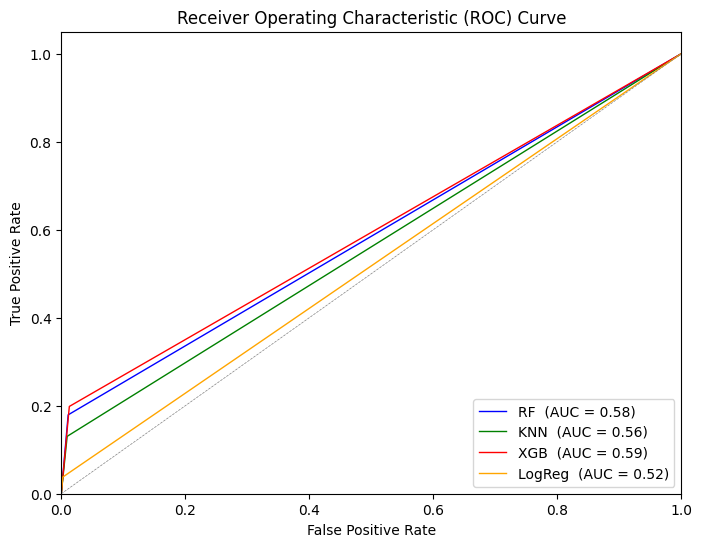

In [115]:
df_result, roc_data = runAndPredict(5,X_train_scaled, y_train, X_test_scaled, y_test, df_result, '' )
plot_roc_curve(roc_data)

Anpassung der Algorithmen

[INFO] Model RF Algo started...
[INFO] Model RF finished.
[INFO] Model KNN Algo started...
[INFO] Model KNN finished.
[INFO] Model XGB Algo started...
[INFO] Model XGB finished.
[INFO] Model LogReg Algo started...
[INFO] Model LogReg finished.


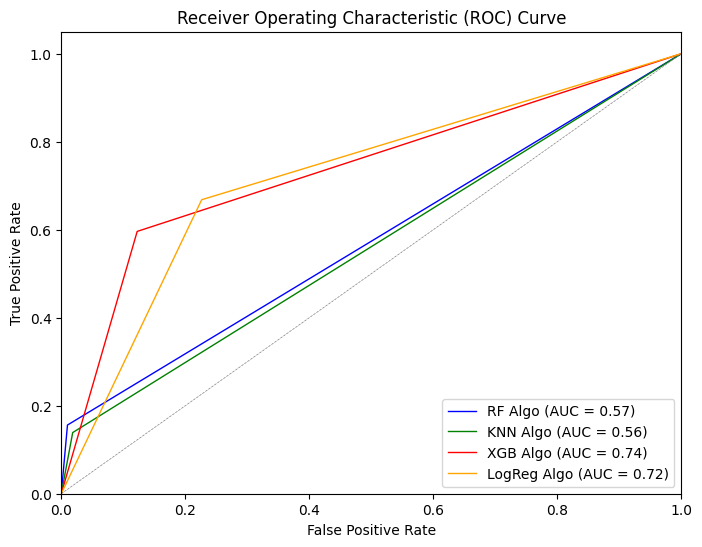

In [118]:
df_result, roc_data_algo = runAndPredict(5,X_train_scaled, y_train, X_test_scaled, y_test, df_result, 'Algo', balanced = "balanced", weightVar = 'distance', algo = True )
plot_roc_curve(roc_data_algo)

Undersampling

In [119]:
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=123)
X_us, y_us = rus.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_us))

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size = 0.2, random_state = 123)



Original dataset shape Counter({0: 139974, 1: 10026})
Resampled dataset shape Counter({0: 10026, 1: 10026})


In [120]:
scaler = StandardScaler()
X_train_us_scaled = scaler.fit_transform(X_train_us)
X_test_us_scaled = scaler.transform(X_test_us)

[INFO] Model RF US started...
[INFO] Model RF finished.
[INFO] Model KNN US started...
[INFO] Model KNN finished.
[INFO] Model XGB US started...
[INFO] Model XGB finished.
[INFO] Model LogReg US started...
[INFO] Model LogReg finished.


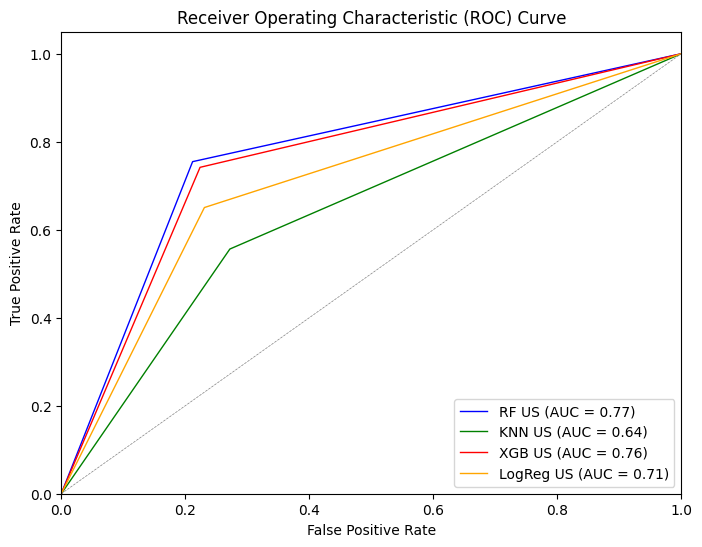

In [122]:
# df_result, roc_data_us = runModelAll(5,X_train_us_scaled, y_train_us, X_test_us_scaled, y_test_us, df_result, 'US' )
df_result, roc_data_us = runAndPredict(5,X_train_us_scaled, y_train_us, X_test_us_scaled, y_test_us, df_result, 'US')
plot_roc_curve(roc_data_us)

Oversampling

In [123]:
print('Original dataset shape %s' % Counter(y))

ros = RandomOverSampler(sampling_strategy='minority')
X_os, y_os = ros.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_os))

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size = 0.2, random_state = 123)



Original dataset shape Counter({0: 139974, 1: 10026})
Resampled dataset shape Counter({1: 139974, 0: 139974})


In [124]:
scaler = StandardScaler()
X_train_os_scaled = scaler.fit_transform(X_train_os)
X_test_os_scaled = scaler.transform(X_test_os)

[INFO] Model RF OS started...
[INFO] Model RF finished.
[INFO] Model KNN OS started...
[INFO] Model KNN finished.
[INFO] Model XGB OS started...
[INFO] Model XGB finished.
[INFO] Model LogReg OS started...
[INFO] Model LogReg finished.


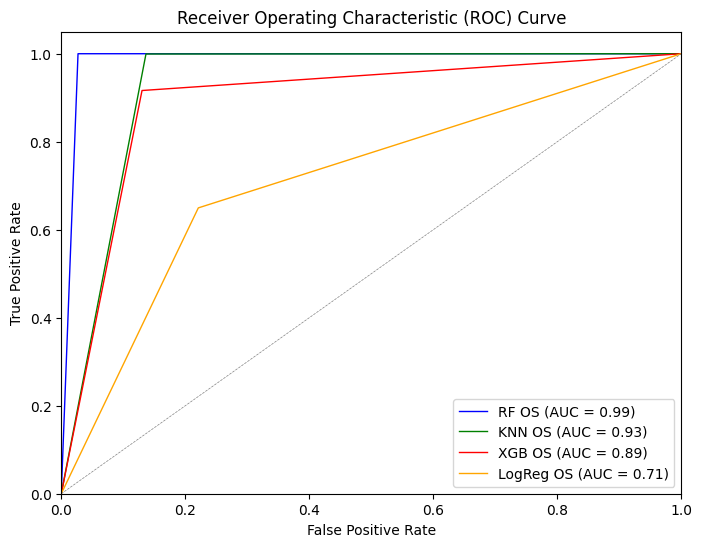

In [126]:
df_result, roc_data_os = runAndPredict(5,X_train_os_scaled, y_train_os, X_test_os_scaled, y_test_os, df_result, 'OS' )
plot_roc_curve(roc_data_os)

SMOTE

In [127]:
from imblearn.over_sampling import SMOTE

print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Neue Klassenverteilung nach SMOTE:', Counter(y_train_smote))



Original dataset shape Counter({0: 111960, 1: 8040})
Neue Klassenverteilung nach SMOTE: Counter({0: 111960, 1: 111960})


In [128]:
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test)

[INFO] Model RF SMOTE started...
[INFO] Model RF finished.
[INFO] Model KNN SMOTE started...
[INFO] Model KNN finished.
[INFO] Model XGB SMOTE started...
[INFO] Model XGB finished.
[INFO] Model LogReg SMOTE started...
[INFO] Model LogReg finished.


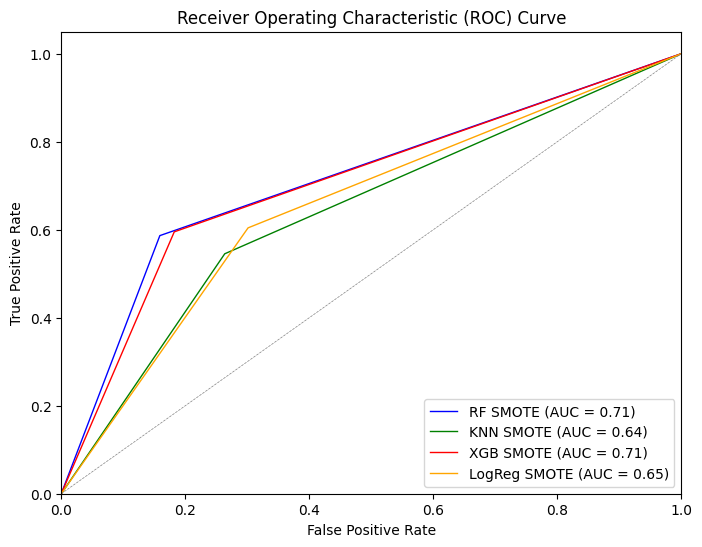

In [129]:
df_result, roc_data_smote = runAndPredict(5,X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test, df_result, 'SMOTE')
plot_roc_curve(roc_data_smote)

In [130]:
df_result

,model,accuracy,precision,recall,f1,roc_auc
0,RF,0.935300,0.533733,0.179255,0.268375,0.584077
1,KNN,0.933567,0.493333,0.130413,0.206292,0.560459
2,XGB,0.934800,0.519789,0.198389,0.287172,0.592698
3,LogReg,0.934133,0.535714,0.037764,0.070555,0.517722
4,RF Algo,0.934800,0.525424,0.156093,0.240683,0.573049
5,KNN Algo,0.925800,0.348485,0.138973,0.198704,0.560277
6,XGB Algo,0.858933,0.256610,0.596173,0.358788,0.736867
7,LogReg Algo,0.766533,0.172967,0.668177,0.274798,0.720842
8,RF US,0.771379,0.782295,0.754717,0.768259,0.771450
9,KNN US,0.641735,0.673482,0.556107,0.609192,0.642100
